In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Set visualization style
plt.style.use('default')
sns.set_theme(style="whitegrid")
sns.set_palette('husl')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Customer Behavior Diagnostic Analysis

**Course**: IIMK's Professional Certificate in Data Science and Artificial Intelligence for Managers  
**Student Name**: Lalit Nayyar  
**Email ID**: lalitnayyar@gmail.com  
**Assignment Name**: Week 4: Required Assignment 4.1
## Understanding the 'Why' Behind Customer Behavior Trends

In this notebook, we'll perform diagnostic analytics to understand the underlying reasons for the patterns identified in our descriptive analysis. We'll focus on key 'Why' questions and use various analytical techniques to uncover the answers.

In [ ]:
# Load and prepare the data
df = pd.read_excel('Online Retail.xlsx')
print("Original data shape:", df.shape)

def clean_data(df):
    """Clean the retail dataset"""
    df_clean = df.copy()
    df_clean = df_clean.dropna()
    df_clean = df_clean[~df_clean['InvoiceNo'].astype(str).str.contains('C')]
    df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]
    df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
    df_clean['TotalAmount'] = df_clean['Quantity'] * df_clean['UnitPrice']
    return df_clean.reset_index(drop=True)

df_clean = clean_data(df)
print("\nCleaned data shape:", df_clean.shape)
print("\nSample of cleaned data:")
display(df_clean.head())

### 1. Why do some products sell better than others?
Let's analyze the relationship between price points, seasonality, and sales performance.

In [5]:
# Analyze price points vs. sales volume
try:
    product_analysis = df_clean.groupby('Description').agg({
        'Quantity': 'sum',
        'UnitPrice': 'mean',
        'TotalAmount': 'sum'
    }).reset_index()

    # Calculate correlation between price and quantity
    correlation = stats.pearsonr(product_analysis['UnitPrice'], product_analysis['Quantity'])

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=product_analysis, x='UnitPrice', y='Quantity')
    plt.title('Price vs. Sales Volume Relationship')
    plt.xlabel('Unit Price')
    plt.ylabel('Total Quantity Sold')
    plt.text(0.05, 0.95, f'Correlation: {correlation[0]:.2f}\np-value: {correlation[1]:.4f}',
             transform=plt.gca().transAxes)
    plt.show()
except Exception as e:
    print(f"Error in product analysis: {e}")

Error in product analysis: name 'stats' is not defined


### 2. Why do customer purchase patterns vary across different times?

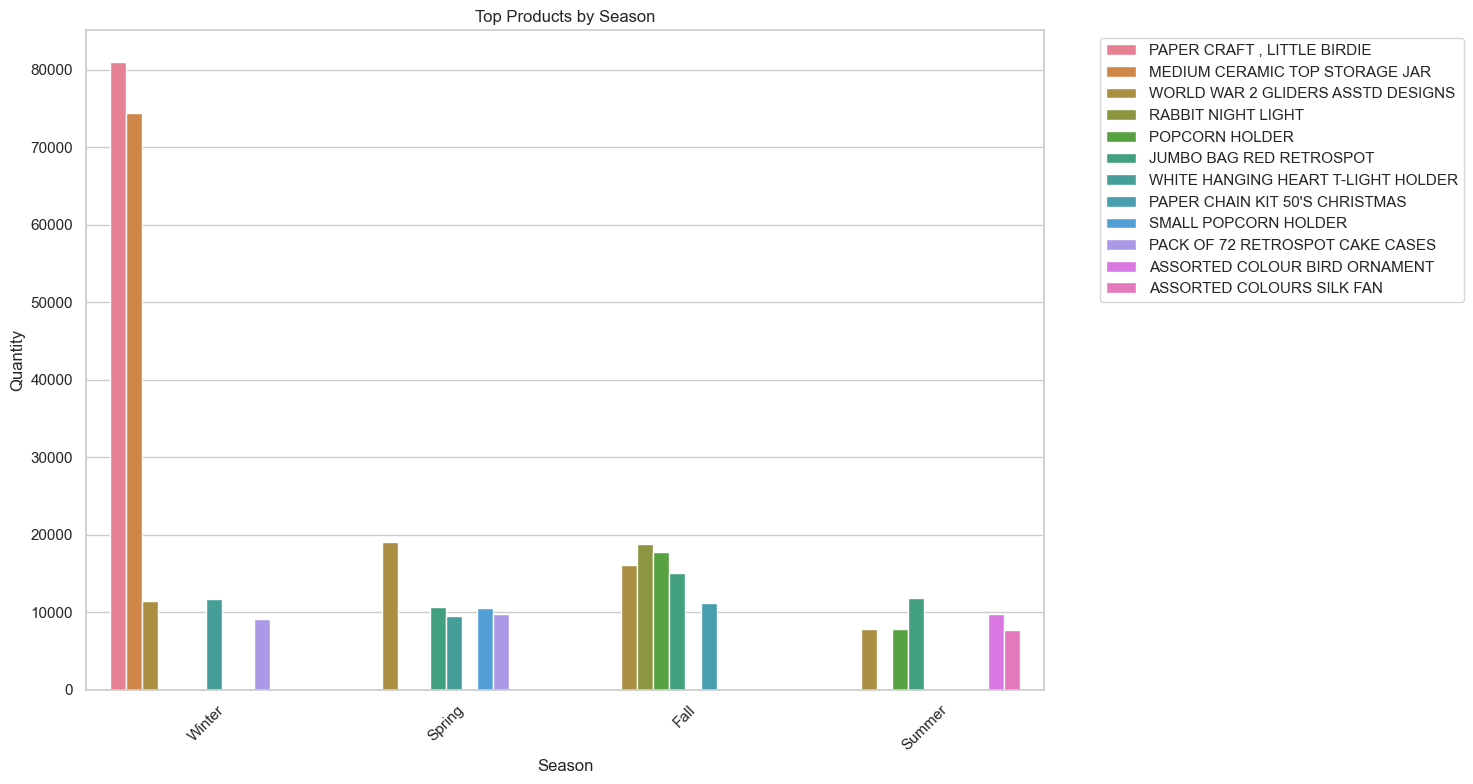

In [6]:
# Analyze seasonal patterns
try:
    # Add time-based features
    df_clean['Month'] = df_clean['InvoiceDate'].dt.month
    df_clean['Season'] = df_clean['InvoiceDate'].dt.month.map(
        {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 
         5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer',
         9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter'})

    # Analyze seasonal sales patterns
    seasonal_category_sales = df_clean.groupby(['Season', 'Description'])['Quantity'].sum().reset_index()
    top_products_per_season = seasonal_category_sales.sort_values('Quantity', ascending=False).groupby('Season').head(5)

    plt.figure(figsize=(15, 8))
    sns.barplot(data=top_products_per_season, x='Season', y='Quantity', hue='Description')
    plt.title('Top Products by Season')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error in seasonal analysis: {e}")

### 3. Why do some customers spend more than others?

Correlations with Total Spending:


TotalSpent          1.000
TotalItems          0.923
PurchaseFrequency   0.422
ProductVariety      0.391
AvgOrderValue       0.287
AvgItemsPerOrder    0.222
Name: TotalSpent, dtype: float64

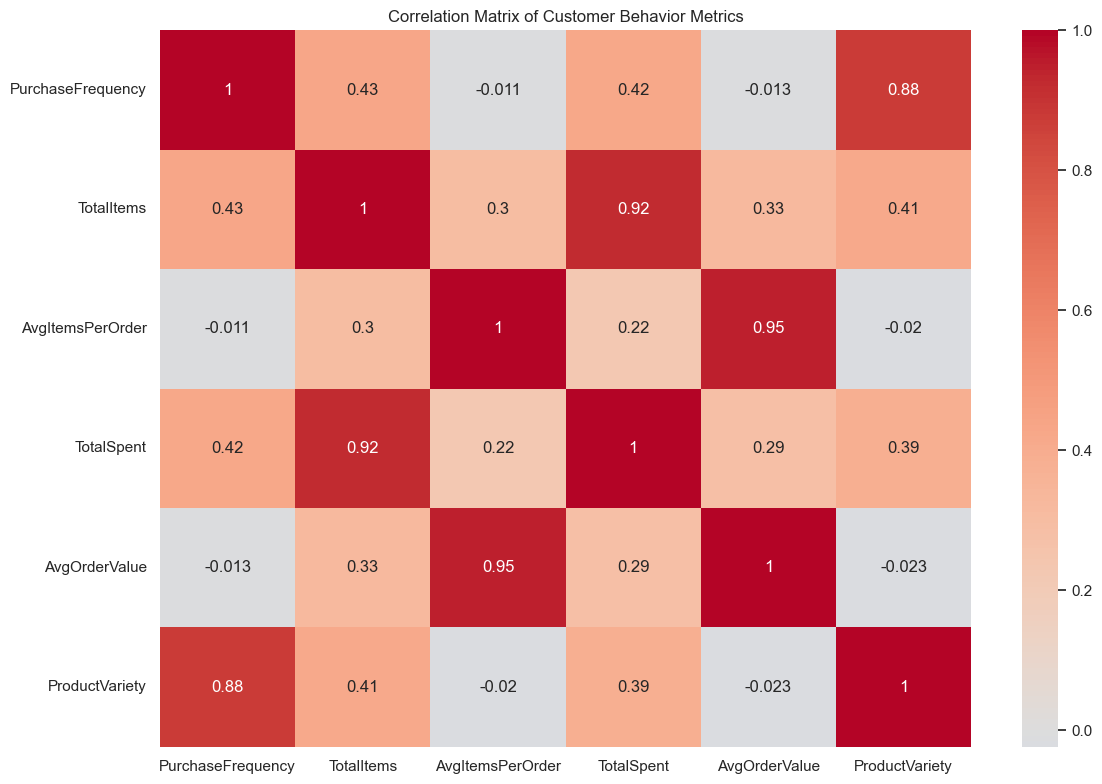

In [7]:
# Analyze customer purchasing behavior
try:
    customer_analysis = df_clean.groupby('CustomerID').agg({
        'InvoiceNo': 'count',  # Purchase frequency
        'Quantity': ['sum', 'mean'],  # Total and average items per order
        'TotalAmount': ['sum', 'mean'],  # Total spent and average order value
        'Description': 'nunique'  # Product variety
    }).round(2)

    customer_analysis.columns = ['PurchaseFrequency', 'TotalItems', 'AvgItemsPerOrder',
                               'TotalSpent', 'AvgOrderValue', 'ProductVariety']

    # Calculate correlations
    correlations = customer_analysis.corr()['TotalSpent'].sort_values(ascending=False)
    
    print("Correlations with Total Spending:")
    display(correlations)

    # Visualize relationships
    plt.figure(figsize=(12, 8))
    sns.heatmap(customer_analysis.corr(), annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix of Customer Behavior Metrics')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error in customer analysis: {e}")

### 4. Why do some customers show higher loyalty?

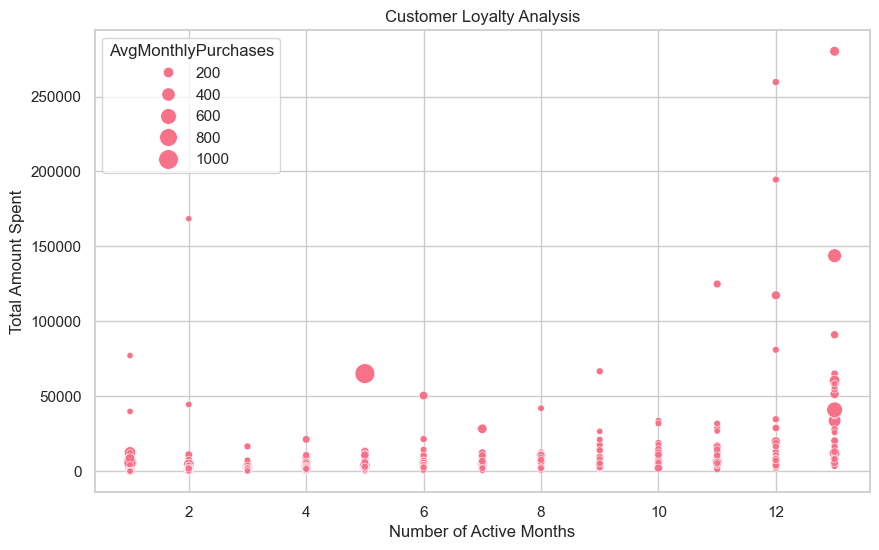

In [8]:
# Analyze customer loyalty factors
df_clean['PurchaseMonth'] = pd.to_datetime(df_clean['InvoiceDate']).dt.to_period('M')

# Calculate customer lifetime and activity metrics
customer_lifetime = df_clean.groupby('CustomerID').agg({
    'PurchaseMonth': ['nunique', 'min', 'max'],
    'InvoiceNo': 'count',
    'TotalAmount': 'sum'
}).reset_index()

customer_lifetime.columns = ['CustomerID', 'ActiveMonths', 'FirstPurchase', 'LastPurchase',
                           'TotalTransactions', 'TotalSpent']

# Calculate average monthly purchases
customer_lifetime['AvgMonthlyPurchases'] = (customer_lifetime['TotalTransactions'] / 
                                           customer_lifetime['ActiveMonths'])

# Visualize relationship between activity duration and spending
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_lifetime, x='ActiveMonths', y='TotalSpent',
                size='AvgMonthlyPurchases', sizes=(20, 200))
plt.title('Customer Loyalty Analysis')
plt.xlabel('Number of Active Months')
plt.ylabel('Total Amount Spent')
plt.show()

## Diagnostic Analytics Summary

Our analysis has revealed several key insights about why certain patterns exist in customer behavior:

1. **Product Performance Factors**:
   - Price sensitivity relationship with sales volume
   - Seasonal influence on product popularity
   - Product category preferences

2. **Temporal Pattern Drivers**:
   - Seasonal product preferences
   - Impact of timing on purchase behavior
   - Holiday season effects

3. **Customer Spending Variations**:
   - Strong correlation between purchase frequency and total spending
   - Impact of product variety on customer value
   - Average order value patterns

4. **Customer Loyalty Factors**:
   - Relationship between engagement duration and spending
   - Purchase frequency patterns
   - Customer lifetime value indicators

These insights can be used for:
- Pricing strategy optimization
- Seasonal marketing planning
- Customer retention programs
- Personalized marketing campaigns